<a href="https://colab.research.google.com/github/vtecftwy/fastbook/blob/master/04_mnist_full_set_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a simplified version of `04_mnist_basic` that you can use to rerun with the full MNIST dataset.

It includes the two steps:
- Pixel Similarity, applied to the full dataset. Code is provided.
- SGD, with a structure but no code provided. For this section, inspire yourself from the [notebook](https://github.com/badreldin2/UnpackAICourse/blob/65a629d4834b666585c51671bcd5eff39fefe6b0/SGD_MNIST_Putting_it_all_together.ipynb) made by Badreldin and explained in his [medium article](https://medium.com/unpackai/sgd-mnist-putting-it-all-together-ebd4ec91d7b1). Also look at the [article](https://medium.com/unpackai/nonlinearity-and-neural-networks-2ffaaac0e6ff) by Gayan

In [5]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [6]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Rerun Chapter 4 with the full MNIST dataset

## Load full MNIST dataset

We are try to rerun the two classifiers built before to classify images as a 3 or a 7, but using the full dataset with 10 digits. So let's download the full MNIST datasets:

In [7]:
path = untar_data(URLs.MNIST)    # Full dataset (0s to 9s)

In [8]:
Path.BASE_PATH = path

We can see what's in this directory by using `ls`, a method added by fastai. This method returns an object of a special fastai class called `L`, which has all the same functionality of Python's built-in `list`, plus a lot more. One of its handy features is that, when printed, it displays the count of items, before listing the items themselves (if there are more than 10 items, it just shows the first few):

In [55]:
path.ls()

(#2) [Path('testing'),Path('training')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set). Note, though, that the names of both image folders have changed: `train` into `training` and `valid` into `testing`. Keep this in mind when you look for images in the code below.

Let's see what's inside the training set:

In [10]:
(path/'training').ls()

(#10) [Path('training/2'),Path('training/0'),Path('training/4'),Path('training/3'),Path('training/1'),Path('training/5'),Path('training/8'),Path('training/7'),Path('training/6'),Path('training/9')]

There's a folder for each digit from 0s to 9s. Let's take a look in one of these folders (using `sorted` to ensure we all get the same order of files). To do so, it is convenient to use a `dict`, indexed by the digit (0 -> 9). It prevents us from creating 10 different variables and from writing 10 times tvery similar code. We also could use a list of lists.
``` python
    paths_dict = {0: [list of the paths to images of 0],
                  1: [list of the paths to images of 1],

                  i: [list of the paths to images of i],

                  9: [list of the paths to images of 9],
                 }
```

In [11]:
paths_dict = {}         # Create an empty dictionary to hold the paths list for each digit
for i in range(10):
    paths_dict[i] = (path/'training'/f"{i}").ls().sorted()   # add the list of path for digit i to the dict

paths_dict

{0: (#5923) [Path('training/0/1.png'),Path('training/0/1000.png'),Path('training/0/10005.png'),Path('training/0/10010.png'),Path('training/0/10022.png'),Path('training/0/10025.png'),Path('training/0/10026.png'),Path('training/0/10045.png'),Path('training/0/10069.png'),Path('training/0/10071.png')...],
 1: (#6742) [Path('training/1/10006.png'),Path('training/1/10007.png'),Path('training/1/1002.png'),Path('training/1/10020.png'),Path('training/1/10027.png'),Path('training/1/1003.png'),Path('training/1/10040.png'),Path('training/1/10048.png'),Path('training/1/10058.png'),Path('training/1/10067.png')...],
 2: (#5958) [Path('training/2/10009.png'),Path('training/2/10016.png'),Path('training/2/10024.png'),Path('training/2/10029.png'),Path('training/2/10072.png'),Path('training/2/10073.png'),Path('training/2/10075.png'),Path('training/2/10078.png'),Path('training/2/10081.png'),Path('training/2/10082.png')...],
 3: (#6131) [Path('training/3/10.png'),Path('training/3/10000.png'),Path('training/

Let’s take a look at one image for each of the digits:

In [12]:
for i in range(10):
    img_paths = paths_dict[i][3]
    img = Image.open(img_paths)
    display(img)

We can store the image in a tensor and slice it to pick some part of the image. We then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:

## Baseline model: Pixel Similarity

So, here is a first idea: how about we find the average pixel value for every pixel for each digit (0 to 9). Then, to classify an image as one digit or the other, we see which of these ideal digits the image is most similar to. This certainly seems like it should be better than nothing, so it will make a good baseline.

Step one for our simple model is to get the average of pixel values for the groups of images for each pixel.

Let's create a tensor containing all of the images representing a single digit, stacked together. We use the same list comnprehension as in `04_mnist_basic`. But since we have 10 groups, we again use a dictionary indexed with the digit 0 to 9, to hold the stacked images, instead of 10 variables. You also can use a list of tensors here. There are also other methods that may be faster.

In [13]:
tensors_dict = {}
for i in range(10):
    tensors_dict[i] = [tensor(Image.open(o)) for o in paths_dict[i]]

In [14]:
# Show the number of images for each digit
print(f'Total number of images: {sum([len(v) for k, v in tensors_dict.items()]):,d}')
display([f"{len(v):,d} images for {k}" for k, v in tensors_dict.items()])


Total number of images: 60,000


['5,923 images for 0',
 '6,742 images for 1',
 '5,958 images for 2',
 '6,131 images for 3',
 '5,842 images for 4',
 '5,421 images for 5',
 '5,918 images for 6',
 '6,265 images for 7',
 '5,851 images for 8',
 '5,949 images for 9']

We'll also check that one of the images looks okay. Since we now have tensors (which Jupyter by default will print as values), rather than PIL images (which Jupyter by default will display as images), we need to use fastai's `show_image` function to display it:

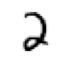

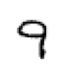

In [15]:
show_image(tensors_dict[2][1])
show_image(tensors_dict[9][1]);

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a *rank-3 tensor*. We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called `stack` that we can use for this purpose.

Some operations in PyTorch, such as taking a mean, require us to *cast* our integer types to float types. Since we'll be needing this later, we'll also cast our stacked tensor to `float` now. Casting in PyTorch is as simple as typing the name of the type you wish to cast to, and treating it as a method.

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:

In [16]:
# Calculate the stacked tensor for each of the digit and store that tensor in a dictionary index by digit
stacked_tensors_dict = {}
for digit, img_tensor in tensors_dict.items():
    stacked_tensors_dict[digit] = torch.stack(img_tensor).float()/255

Perhaps the most important attribute of a tensor is its *shape*. This tells you the length of each axis. In this case, we can see that we have around 6,000 images for each digit, each image of size 28×28 pixels. There is nothing specifically about this tensor that says that the first axis is the number of images, the second is the height, and the third is the width—the semantics of a tensor are entirely up to us, and how we construct it. As far as PyTorch is concerned, it is just a bunch of numbers in memory.

In [17]:
print('Shapes of image tensor for each digit:')
for digit, img_tensor in stacked_tensors_dict.items():
    print('   ', digit, ': ', stacked_tensors_dict[digit].shape)

Shapes of image tensor for each digit:
    0 :  torch.Size([5923, 28, 28])
    1 :  torch.Size([6742, 28, 28])
    2 :  torch.Size([5958, 28, 28])
    3 :  torch.Size([6131, 28, 28])
    4 :  torch.Size([5842, 28, 28])
    5 :  torch.Size([5421, 28, 28])
    6 :  torch.Size([5918, 28, 28])
    7 :  torch.Size([6265, 28, 28])
    8 :  torch.Size([5851, 28, 28])
    9 :  torch.Size([5949, 28, 28])


Finally, we can compute what the ideal digit image looks like. We calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor. This is the dimension that indexes over all the images.

In other words, for every pixel position, this will compute the average of that pixel over all images. The result will be one value for every pixel position, or a single image. Here it is:

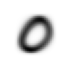

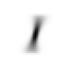

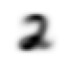

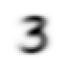

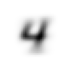

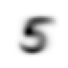

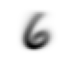

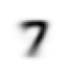

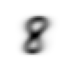

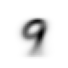

In [18]:
means_dict = {}
for digit, tnsr in stacked_tensors_dict.items():
    means_dict[digit] = stacked_tensors_dict[digit].mean(0)
    show_image(means_dict[digit])

According to this dataset, these are the ideal images for each of the digits

Let's now pick an arbitrary 3 and measure its *distance* from our "ideal digits."

> **Stop and Think!**: How would you calculate how similar a particular image is to each of our ideal digits? Remember to step away from this book and jot down some ideas before you move on! Research shows that recall and understanding improves dramatically when you are engaged with the learning process by solving problems, experimenting, and trying new ideas yourself

Here's a sample image of one digit:

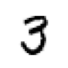

In [19]:
selected_digit = 3
img = stacked_tensors_dict[selected_digit][2]
show_image(img);

Let's compare again our Mean Absolute Error (MAE) and Mean Square Error (MSE)

In [20]:
dist_3_mae = (img - means_dict[3]).abs().mean()
dist_3_mse = ((img - means_dict[3])**2).mean().sqrt()
dist_3_mae, dist_3_mse

(tensor(0.1100), tensor(0.1980))

In [21]:
dist_7_mae = (img - means_dict[7]).abs().mean()
dist_7_mse = ((img - means_dict[7])**2).mean().sqrt()
dist_7_mae, dist_7_mse

(tensor(0.1541), tensor(0.2974))

Let's visualize what these distances mean:

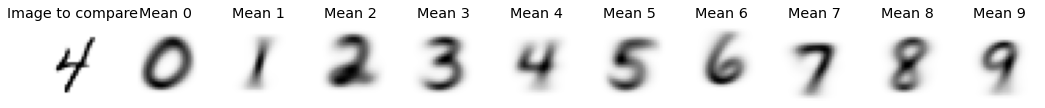


Simple Difference:


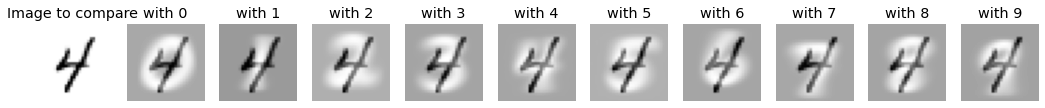


MAE - Mean Absolute Error:


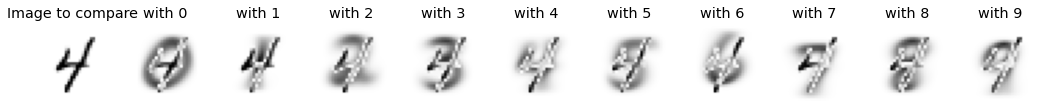


MSE - Mean Squared Error:


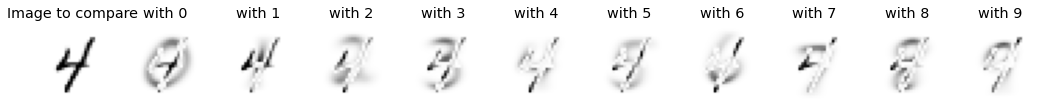

In [22]:
digit = 4
img = stacked_tensors_dict[digit][10]

fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(18,5))
for i in range(10):
    show_image(means_dict[i], title=f"Mean {i}", ax=axs[i+1])
show_image(img, title='Image to compare', ax=axs[0])
plt.show()

print('\nSimple Difference:')
fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(18,5))
for i in range(10):
    show_image((img - means_dict[i]), title=f'with {i}', ax=axs[i+1])
show_image(img, title='Image to compare', ax=axs[0])
plt.show()

print('\nMAE - Mean Absolute Error:')
fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(18,5))
for i in range(10):
    show_image((img - means_dict[i]).abs(), title=f'with {i}', ax=axs[i+1])
show_image(img, title='Image to compare', ax=axs[0])
plt.show()

print('\nMSE - Mean Squared Error:')
fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(18,5))
for i in range(10):
    show_image((img - means_dict[i]).square(), title=f'with {i}', ax=axs[i+1])
show_image(img, title='Image to compare', ax=axs[0])
plt.show()

PyTorch already provides both of these as *loss functions*. You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as `F` (and is available by default under that name in fastai):

In [23]:
F.l1_loss(img.float(),means_dict[7]), F.mse_loss(img, means_dict[7]).sqrt()  

(tensor(0.1161), tensor(0.2299))

Here `mse` stands for *mean squared error*, and `l1` refers to the standard mathematical jargon for *mean absolute value* (in math it's called the *L1 norm*).

So, is our baseline model any good? To quantify this, we must define a metric.

c over a *validation set*. This is so that we don't inadvertently overfit—that is, train a model to work well only on our training data. This is not really a risk with the pixel similarity model we're using here as a first try, since it has no trained components, but we'll use a validation set anyway to follow normal practices and to be ready for our second try later.

To get a validation set we need to remove some of the data from training entirely, so it is not seen by the model at all. As it turns out, the creators of the MNIST dataset have already done this for us. Do you remember how there was a whole separate directory called *valid*? That's what this directory is for!

So to start with, let's create tensors for our 3s and 7s from that directory. These are the tensors we will use to calculate a metric measuring the quality of our first-try model, which measures distance from an ideal image:

### Create validation set

In [24]:
valid_tensors_dict = {}

for digit, tnrs in stacked_tensors_dict.items():
    valid_tensors_dict[digit] = torch.stack([tensor(Image.open(o)) 
                                             for o in (path/'testing'/f"{digit}").ls()])
    valid_tensors_dict[digit] = valid_tensors_dict[digit].float()/255
    print('shape for',digit, ':', valid_tensors_dict[digit].shape)

shape for 0 : torch.Size([980, 28, 28])
shape for 1 : torch.Size([1135, 28, 28])
shape for 2 : torch.Size([1032, 28, 28])
shape for 3 : torch.Size([1010, 28, 28])
shape for 4 : torch.Size([982, 28, 28])
shape for 5 : torch.Size([892, 28, 28])
shape for 6 : torch.Size([958, 28, 28])
shape for 7 : torch.Size([1028, 28, 28])
shape for 8 : torch.Size([974, 28, 28])
shape for 9 : torch.Size([1009, 28, 28])


It's good to get in the habit of checking shapes as you go. Here we see 10 tensors, each representing one digit validation set of about 1,000 images of size 28×28. Total number of validation images is 10,000.

In [25]:
print('Shapes of image tensor for each digit:')
for digit, tnrs in valid_tensors_dict.items():
    print(' shape for',digit, ':', valid_tensors_dict[digit].shape)

Shapes of image tensor for each digit:
 shape for 0 : torch.Size([980, 28, 28])
 shape for 1 : torch.Size([1135, 28, 28])
 shape for 2 : torch.Size([1032, 28, 28])
 shape for 3 : torch.Size([1010, 28, 28])
 shape for 4 : torch.Size([982, 28, 28])
 shape for 5 : torch.Size([892, 28, 28])
 shape for 6 : torch.Size([958, 28, 28])
 shape for 7 : torch.Size([1028, 28, 28])
 shape for 8 : torch.Size([974, 28, 28])
 shape for 9 : torch.Size([1009, 28, 28])


### Loss - Metric

We ultimately want to write a function, `evaluate_digit()`, that will return the most probable digit for one inage we pass to the function.

**STOP AND THINK**:

- How would you extrapolate the approach for used in the sample MNIST case, when we only had two digits? 
- In this casem you cannot use the same method because we have more than two digits this time. 
- A function `is_3` as `True` or `False` is not enough. 



Hint for one possible solution: 
- compare the distances between one image and each of the mean images, then assume that the image corresponds to the digit with the smallest distance.

Code for this approach:

1. We keep the same distance as before, that is MAE:

In [26]:
def mnist_distance(a, b): 
    return (a - b).abs().mean((-1, -2))

mnist_distance(img, means_dict[7])

tensor(0.1161)

2. We compute the distance to each digit mean

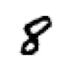

Distance between image and 0 is 0.1808202564716339 
Distance between image and 1 is 0.1442546397447586 
Distance between image and 2 is 0.17209382355213165 
Distance between image and 3 is 0.17300643026828766 
Distance between image and 4 is 0.15727555751800537 
Distance between image and 5 is 0.15030020475387573 
Distance between image and 6 is 0.17104557156562805 
Distance between image and 7 is 0.15621329843997955 
Distance between image and 8 is 0.12615351378917694 
Distance between image and 9 is 0.1434987485408783 


In [27]:
# Select an image to compate
img_tnsr = valid_tensors_dict[8][559]
show_image(img_tnsr)
plt.show()

for i in range(10):
    print(f"Distance between image and {i} is {mnist_distance(img_tnsr, means_dict[i])} ")

The smallest distance should represent the correct digit. In this case it is correct.

With broadcasting, we also can apply the distance to all the images of one class/digit at the same time. `mnist_distance` should return a tensor with the distances for all the images in the batch.

In [28]:
# Select a batch with all the images representing one digit
img_tnsr = stacked_tensors_dict[8]

distances = mnist_distance(img_tnsr, means_dict[7])
display(distances.shape)
display(distances)

torch.Size([5851])

tensor([0.1501, 0.1984, 0.1541,  ..., 0.1339, 0.1280, 0.1585])

In [29]:
# Show distances to all the digits
img_tnsr = stacked_tensors_dict[8]

for i in range(10):
    display(mnist_distance(img_tnsr, means_dict[i]))

tensor([0.1795, 0.2126, 0.1797,  ..., 0.1697, 0.1837, 0.1942])

tensor([0.1039, 0.2042, 0.0930,  ..., 0.1016, 0.0990, 0.1375])

tensor([0.1480, 0.2038, 0.1472,  ..., 0.1283, 0.1469, 0.1563])

tensor([0.1456, 0.1777, 0.1394,  ..., 0.1344, 0.1268, 0.1538])

tensor([0.1559, 0.2038, 0.1607,  ..., 0.1249, 0.1370, 0.1435])

tensor([0.1481, 0.1930, 0.1450,  ..., 0.1308, 0.1336, 0.1525])

tensor([0.1612, 0.1939, 0.1614,  ..., 0.1305, 0.1458, 0.1656])

tensor([0.1501, 0.1984, 0.1541,  ..., 0.1339, 0.1280, 0.1585])

tensor([0.1197, 0.1959, 0.1252,  ..., 0.1110, 0.1156, 0.1399])

tensor([0.1483, 0.1949, 0.1511,  ..., 0.1262, 0.1202, 0.1497])

Let's see how are can compute all the distances from one image tensor batch to each of the digit means in a few operations only. 

1. Let's see what we have to start with:
    - we start from a batch of image tensors `image_tensor_batch` of shape `(nbr_img, 28, 28)`
    - `mnist_distance(image_tensor_batch)` returns a tensor of shape `(nbr_img)`

In [30]:
img_batch_tnsr = stacked_tensors_dict[8]
print('Shape of batch_tnsr:', img_batch_tnsr.shape)

distances = mnist_distance(img_tnsr, means_dict[0])
print('Shape of distances: ', distances.shape)

Shape of batch_tnsr: torch.Size([5851, 28, 28])
Shape of distances:  torch.Size([5851])


2. Now we want to have all distances for all digits in a dimension-2 tensor of shape `(nbr of images, 10)`. That is a tensor with the same number of samples/images as the batch and a distance to each digit. Using tensors instead of list or other data sructure will allow us to use fast tensor calculation to easily extract which digit corresponds to each image, as opposed to slow Python loop through all the images in Python. One way to do it:
    - use the `torch.stack` function to stack the distances tensors for each of the digits into one single tensor

In [31]:
distances = torch.stack([mnist_distance(img_tnsr, m) for m in means_dict.values()], dim=1)
display(distances)
distances.shape

tensor([[0.1795, 0.1039, 0.1480,  ..., 0.1501, 0.1197, 0.1483],
        [0.2126, 0.2042, 0.2038,  ..., 0.1984, 0.1959, 0.1949],
        [0.1797, 0.0930, 0.1472,  ..., 0.1541, 0.1252, 0.1511],
        ...,
        [0.1697, 0.1016, 0.1283,  ..., 0.1339, 0.1110, 0.1262],
        [0.1837, 0.0990, 0.1469,  ..., 0.1280, 0.1156, 0.1202],
        [0.1942, 0.1375, 0.1563,  ..., 0.1585, 0.1399, 0.1497]])

torch.Size([5851, 10])

"decrypting" code above: `torch.stack([mnist_distance(img_tnsr, m) for m in means_dict.values()], dim=1)`
- Signature of stack: `torch.stack(tensors, dim=0)` [doc](https://pytorch.org/docs/stable/generated/torch.stack.html):
    - `tensors` is a sequence of tensors to concatenate, for instance a list of tensors
    - `dim` is the dimension to insert. Has to be between 0 and the number of dimensions of concatenated, In our case, `dim` is 1 as we want to stack the 10 values for each images. You can try other values and see what it gives.
- `[mnist_distance(img_tnsr, m) for m in means_dict.values()]`:
    - list comprehension to get a list of the 10 distances, one for each digit. Remember that means_dict keeps the ten mean images reporesenting the "ideal" difit. The list comprehension is equivalent to:
    ```python
        tensor_list = []
        for mean in means_dict.values():
            tensor_list.append(mnist_distance(img_tnsr, m))
    ```

The code is passing a list of 10 dimension-1 tensors (shape = `(number of images in the batch)`) to `torch.stack`, to create a dimension-2 tensor of shape `(number of images in the batch, 10)`

Now we have a tensor `distances` with the distance of each image to the ten means. We can index it to get the distances of any image to the ten means.

In [32]:
distances[120:125, :]

tensor([[0.1680, 0.1831, 0.1666, 0.1545, 0.1572, 0.1537, 0.1583, 0.1848, 0.1462, 0.1656],
        [0.1888, 0.1888, 0.1770, 0.1895, 0.1614, 0.1828, 0.1675, 0.1957, 0.1638, 0.1754],
        [0.1686, 0.1799, 0.1772, 0.1616, 0.1734, 0.1523, 0.1580, 0.1956, 0.1547, 0.1768],
        [0.1796, 0.1059, 0.1646, 0.1448, 0.1495, 0.1309, 0.1498, 0.1442, 0.1367, 0.1318],
        [0.1684, 0.1696, 0.1688, 0.1595, 0.1498, 0.1495, 0.1552, 0.1718, 0.1316, 0.1451]])

3. Select the class/digit for each image in the batch: pick the minimum distance. We will use the method tensor `argmin()` to pick the index with minimum distance, which is the digit corresponding to the minumum distance and therefore our class as we defined it in our approach.

> See how `argmin` works with a single image. We pick one image tensor and show it. We also pick the corresponding distances to the ten digit, i.e. a tensor of shape (10). `argmin()` returns the index of the minimum distance, in this case 8, which corresponds to digit 8.

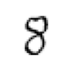

tensor([0.1650, 0.1222, 0.1467, 0.1261, 0.1344, 0.1259, 0.1477, 0.1398, 0.1143, 0.1293])

tensor(0.1143)

In [33]:
img_nbr = 25
show_image(stacked_tensors_dict[8][img_nbr])
plt.show()

distances_for_one_img = distances[img_nbr]
display(distances_for_one_img)
distances_for_one_img.argmin()
distances_for_one_img[8]

When we apply to a batch of images, we need to tell pytorch along which direction the minimum must be seeked. In our case `dim=1`.  It returns a tensor of dimension 1, with shape = `(nbr_img)`

In [34]:
digits = distances.argmin(dim=1)
digits.shape

torch.Size([5851])

```
argmin(input, dim, keepdim=False) -> LongTensor

Returns the indices of the minimum values of a tensor across a dimension.

This is the second value returned by :meth:`torch.min`. See its
documentation for the exact semantics of this method.

Args:
    input (Tensor): the input tensor.
    dim (int): the dimension to reduce. If ``None``, the argmin of the flattened input is returned.
    keepdim (bool): whether the output tensor has :attr:`dim` retained or not. Ignored if ``dim=None``.
```

Using `argmin()` allows us to compute the mimimun for all images, in one step, and with no Python loop.

### Pixel Similarity Classifier

Now we can build our classifier as a function `evaluate_digit` to which we pass an image tensor or a batch of image tensors and which will return a class/digit

In [35]:
def evaluate_digit(x): 
    if x.ndim < 3:
        x = x.unsqueeze(dim=0)
    distances = torch.stack([mnist_distance(x, m) for m in means_dict.values()], dim=1)
    return distances.argmin(dim=1)

>Note: we unsqueeze the tensor when a single image is given instead of a batch, because we expect a batch. Unsqueezing is like translforming a single image into a batch with a single image:
```python
    if x.ndim < 3:
        x = x.unsqueeze(dim=0)
```

See the difference below

In [36]:
img.shape, img.unsqueeze(dim=0).shape

(torch.Size([28, 28]), torch.Size([1, 28, 28]))

Let's test our classifier with a single image:

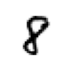

tensor([8])

In [37]:
tnsr = stacked_tensors_dict[8][58]
show_image(tnsr)
plt.show()

evaluate_digit(tnsr)

Let's test our classifier with a small image batch:

In [38]:
tnsr = stacked_tensors_dict[8][58:87]
print('Nbr images: ', tnsr.shape[0])

evaluate_digit(tnsr)

Nbr images:  29


tensor([8, 8, 1, 1, 9, 1, 8, 9, 1, 8, 1, 1, 8, 8, 1, 9, 9, 9, 1, 8, 3, 8, 1, 1, 8, 1, 8, 1, 8])

We can see that the model is not that great ! Some images are correctly evaluated and some are not.

### Evaluation of the classifier
Let's compute the accuracy for the train and the validation set for each class/digit
1. For each class, we evaluate the digit for the full dataset (training and validation)
2. We compute how many are correct and how many are not correct

In [39]:
# One class at the time
digit = 5
tnsr = stacked_tensors_dict[digit]
preds = evaluate_digit(tnsr) 
correct = torch.eq(preds, digit).sum()
incorrect = torch.ne(preds, digit).sum()
correct.item(), incorrect.item(), (correct / preds.shape[0]).item()

(1627, 3794, 0.30012911558151245)

In [40]:
# All digits for training set
for digit in range(10):
    tnsr = stacked_tensors_dict[digit]
    preds = evaluate_digit(tnsr) 
    correct = torch.eq(preds, digit).sum()
    # print(f" - {correct.item():,d} correct digits out or {preds.shape[0]}")
    print(f"Accuracy for {digit}: {(correct / preds.shape[0]).item():1.4f}")

Accuracy for 0: 0.8141
Accuracy for 1: 0.9981
Accuracy for 2: 0.4329
Accuracy for 3: 0.5836
Accuracy for 4: 0.6648
Accuracy for 5: 0.3001
Accuracy for 6: 0.7454
Accuracy for 7: 0.7778
Accuracy for 8: 0.3958
Accuracy for 9: 0.7163


In [41]:
# All digits for validation set
for digit in range(10):
    tnsr = valid_tensors_dict[digit]
    preds = evaluate_digit(tnsr) 
    correct = torch.eq(preds, digit).sum()
    # print(f" - {correct.item():,d} correct digits out or {preds.shape[0]}")
    print(f"Accuracy for {digit}: {(correct / preds.shape[0]).item():1.4f}")

Accuracy for 0: 0.8153
Accuracy for 1: 0.9982
Accuracy for 2: 0.4234
Accuracy for 3: 0.6089
Accuracy for 4: 0.6680
Accuracy for 5: 0.3262
Accuracy for 6: 0.7871
Accuracy for 7: 0.7646
Accuracy for 8: 0.4425
Accuracy for 9: 0.7760


Although this is not awfull, the performance varies a lot for each of the digit. 0 and 1 are well classified byt 5 and 8 are not, for example.

Can we do better if we use another metric? We uses MAE, let's do the same but using RMSE:

In [42]:
# Define a new loss/distance function: mnist_rmse
def mnist_rmse(a, b):
    return ((a - b) ** 2 ).mean((-1, -2)).sqrt()

# Our new classifier will use rmse to compute the distances and pick the minimum
def evaluate_digit_rmse(x): 
    if x.ndim < 3:
        x = x.unsqueeze(dim=0)
    distances = torch.stack([mnist_rmse(x, m) for m in means_dict.values()], dim=1)
    return distances.argmin(dim=1)

Now we can evaluate the performance of this new classifer with the validation set

In [43]:
# All digits for validation set
for digit in range(10):
    tnsr = valid_tensors_dict[digit]
    preds = evaluate_digit_rmse(tnsr) 
    correct = torch.eq(preds, digit).sum()
    # print(f" - {correct.item():,d} correct digits out or {preds.shape[0]}")
    print(f"Accuracy for {digit}: {(correct / preds.shape[0]).item():1.4f}")

Accuracy for 0: 0.8959
Accuracy for 1: 0.9621
Accuracy for 2: 0.7568
Accuracy for 3: 0.8059
Accuracy for 4: 0.8259
Accuracy for 5: 0.6861
Accuracy for 6: 0.8633
Accuracy for 7: 0.8327
Accuracy for 8: 0.7372
Accuracy for 9: 0.8067


We see that the accuracy increases for almost all the digits. 

The base line is not bad, but all in all, it still shows some relativaly low accuracy compared to real model.

## Stochastic Gradient Descent (SGD)

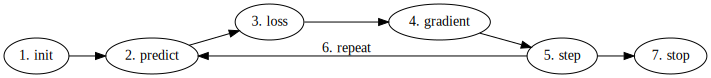

In [44]:
gv('''
"1. init"->"2. predict"->"3. loss"->"4. gradient"->"5. step"->"7. stop"
"5. step"->"2. predict"[label="6. repeat"]
''')

Steps that we are going to require, to turn a function into a machine learning classifier:

1. *Initialize* the weights.
1. For each image, use these weights to *predict* whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

#### Prepare datasets and dataloaders

`train_x` is the set of independant variables (inputs), that is our images. We create  `train_x` tensor by concatenating all the tensors for each digit.

In [45]:
train_x = torch.cat([stacked_tensors_dict[i] for i in range(0,10)]).view(-1, 28*28)

In [46]:
train_x.shape

torch.Size([60000, 784])

As expected, it is a set of 60,000 images represented as a flat one dimension vector of shape 28 x 28 = 784

We need a label for each image, 0 to 9, depending on the digit the image represent. It is not as simple as for the basic MNIST case, as we have more than two classes and the number of images in each class is not equal. There is probably an easier way than the one below !

In [47]:
# Returns a list of 10 sublists, where each sublist consists of a as many times digit as the number of image in the category
l = [ [i] * stacked_tensors_dict[i].shape[0] for i in range(0,10)]

# check the the total number of labels is equal to the numer of images
assert sum([len(sublist) for sublist in l]) == train_x.shape[0] 

In [48]:
# Create a tensor based on the list of labels
label_list = []
for i in range(10):
    label_list.extend(l[i])
assert len(label_list) == train_x.shape[0]

train_y = torch.tensor(label_list).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

The shapes of `train_x` and `train_y` are as expected

A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

In [49]:
dset = list(zip(train_x,train_y))
x, y = dset[0]
x.shape,y

(torch.Size([784]), tensor([0]))

Now we do the same for the validation sets

In [50]:
valid_x = torch.cat([valid_tensors_dict[i] for i in range(0,10)]).view(-1, 28*28)

# Returns a list of 10 sublists, where each sublist consists of a as many times digit as the number of image in the category
l = [ [i] * valid_tensors_dict[i].shape[0] for i in range(0,10)]

# check the the total number of labels is equal to the numer of images
assert sum([len(sublist) for sublist in l]) == valid_x.shape[0] 
print(valid_x.shape)

# Create a tensor based on the list of labels
label_list = []
for i in range(10):
    label_list.extend(l[i])
assert len(label_list) == valid_x.shape[0]

valid_y = torch.tensor(label_list).unsqueeze(1)
print(valid_y.shape)

valid_dset = list(zip(valid_x,valid_y))

torch.Size([10000, 784])
torch.Size([10000, 1])


Datasets are ready. Now we prepare the dataloaders to feed the training loop.

In [51]:
dl = DataLoader(dset, batch_size=5)
valid_dl = DataLoader(valid_dset, batch_size=5)

#### Define the model architecture and parameters

Model is defined by creating functions to compute each of the 7 steps listed above

##### Parameters

Some ideas for your model. You do not have to follow this thinking.

In our model, we need to evaluate the distance from one image (input) to each of the possible classes (0 - 9). So we need to predict 10 values, out of which we will pick the minimum value to predict the correpsonding digit.

In effect,**y** in **y=Wx+b** represents the `distances` between the image **x** and each of the digits. **y** is therefore a vector of shape `(10)`. The prediction is computed from an image **x** which is a vector of shape `(784)`. Therefore **W** must be of shape `(784, 10)`. And **b** must be of the same shape as the output, that is shape `(10)`.

<img src="https://raw.githubusercontent.com/vtecftwy/fastbook/master/images/img_mnist_full_linear_layer.png" height="400px" />


Define a function to create random parameters, and then create **W** and **b** with the correct shapes

In [53]:
def init_params(size, std=1.0): 
    return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28, 10))
bias = init_params(10)

weights.shape, bias.shape

(torch.Size([784, 10]), torch.Size([10]))

##### Define functions to calculate the predictions

In [ ]:
def linear(xb): 
    return xb @ weights + bias


##### Define a function to calculate the loss

##### Define a function to calculate the gradients

##### Define a function performing one step/one epoch

##### Define a function to evaluate the validation accurary

#### Bringing it all together and run training loop

## Comparison with a Resnet model

In [56]:
dls = ImageDataLoaders.from_folder(path, train='training', valid='testing')
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.146955,0.068630,0.979300,01:58


In [ ]:
dls = ImageDataLoaders.from_folder(path, train='training', valid='testing')
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(5, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.236874,13.224614,0.496565,00:16
1,0.389707,0.130539,0.985770,00:16
2,0.087542,0.008495,0.999019,00:16
3,0.018765,0.005704,0.999019,00:16
4,0.006125,0.004612,0.999019,00:16
